In [1]:
import pickle
import datetime
import numpy as np
from pathlib import Path
from matplotlib import pyplot as plt
from scipy.optimize import least_squares
from importlib import reload

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader, random_split

from libs_unet.models import peakyfinder_0001
from libs_unet.training.spec_maker2 import spectrum_maker
#import libs_unet.models.spec_fitting
#reload(libs_unet.models.spec_fitting)
from libs_unet.models.spec_fitting import fit_spec

top_dir = Path.cwd()
datapath = top_dir / 'data'

/Users/matt/CloudGit_local/github/gss/phaseMAP/envs/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
#reference data load
#This dataset has spectra made single and pairs with 80 elements from NIST LIBS data

with open(datapath / 'training' / 'el80_pairs.pickle', 'rb') as f:
    elem_symb = pickle.load(f)
    el_index = pickle.load(f)
    fracs = pickle.load(f)
    wave = pickle.load(f)
    x_data = pickle.load(f)
    y_data = pickle.load(f)

#create dataset
#input needs a placeholder "channel" dimension since single channel
#learned labels already has max_z + 2 channels from spec_array
#data has to match weights which default to float() so cast data as same
#apply a scaling factor to standardize spectra across sources.
nist_sim_mult = 0.58
x_data = nist_sim_mult * torch.tensor(x_data[:,None,:].astype('float32'))
y_data = nist_sim_mult * torch.tensor(y_data.astype('float32'))
x_data[x_data < 0] = 0
y_data[y_data < 0] = 0
#log transform data, add small offset 1 so zero points remain ~zero on log scale
x_data = torch.log(x_data + 1)
y_data = torch.log(y_data + 1)

# set number of elements
max_z = len(elem_symb)

In [3]:
#Load model and parameters for making predictions
#https://pytorch.org/tutorials/beginner/saving_loading_models.html
model = peakyfinder_0001.LIBSUNet(max_z,len(wave))
param_path = top_dir / 'trained_models' / 'el80_pairs_c_0001'
model.load_state_dict(torch.load(param_path))


<All keys matched successfully>

Sample composition
F:0.5
Y:0.5


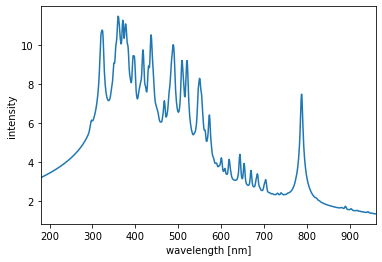

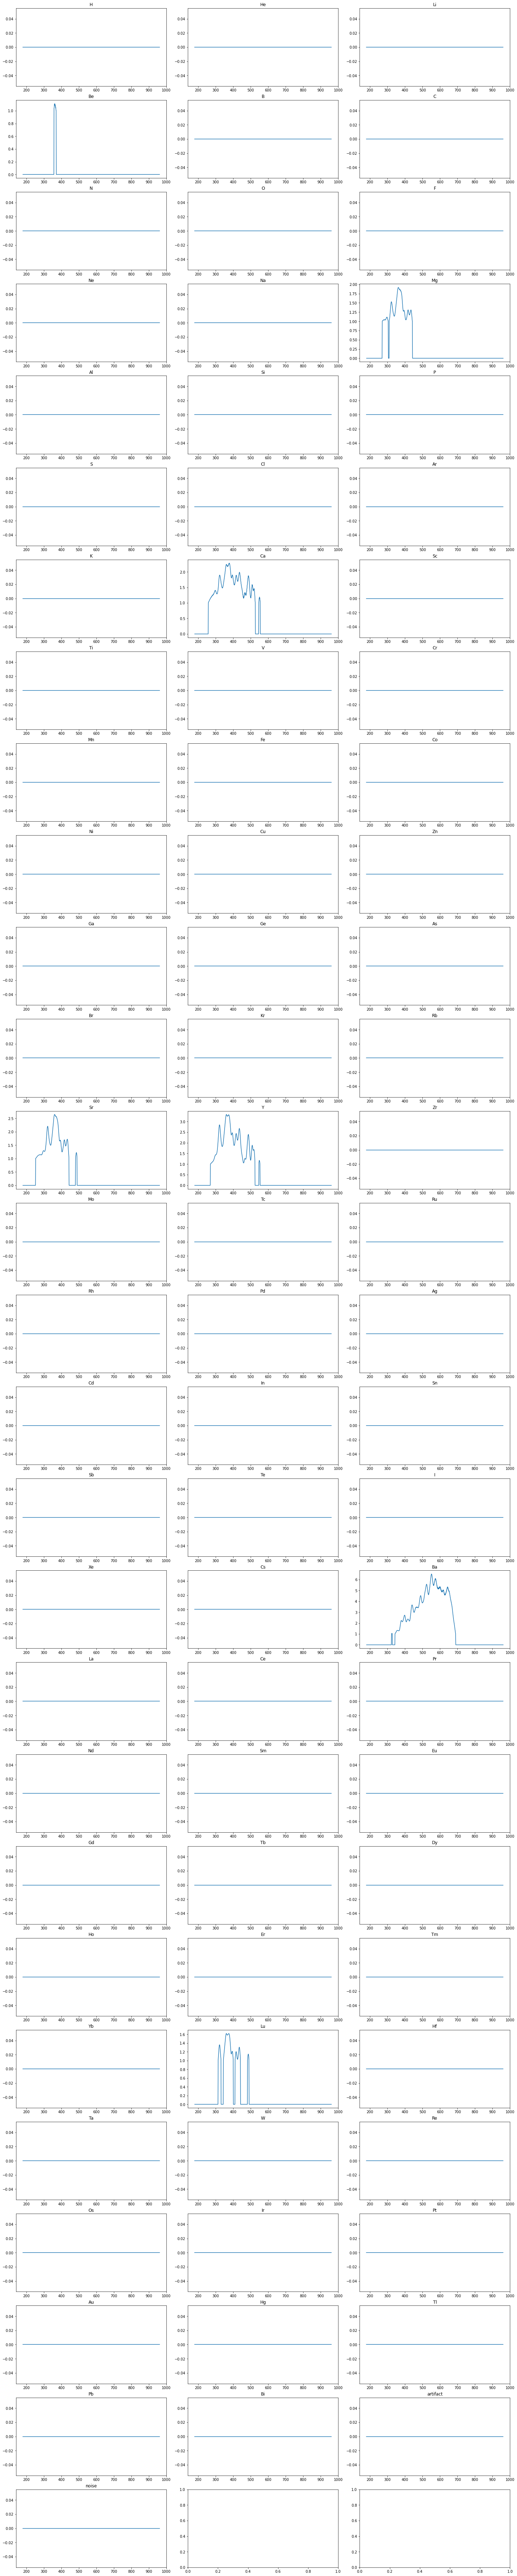

In [4]:
#look at the predicted vs. reference spectra
# sample and predicted data are all scaled and log transformed at this point
i_samp = 1977 #vary up to 9560
x_sample = x_data[i_samp][None, :, :] #need correct dimensions with batch for prediction
y_sample = y_data[i_samp].detach().numpy() #[max_z + 2][782]

#composite spectra and components still in log transformed space used in model
print("Sample composition")
for el in elem_symb[np.nonzero(fracs[i_samp])]:
    print(f"{el}:{fracs[i_samp][el_index[el]]}")

        
#first plot the transformed composite input spectrum we're trying to decompose
plt.plot(wave, x_sample[0][0])
plt.xlabel('wavelength [nm]')
plt.ylabel('intensity')
plt.xlim([np.min(wave), np.max(wave)])
plt.show

#prediction (also transformed at this point)
plot_thresh = 1
model.eval()
with torch.no_grad():
    pred = model(x_sample)
    y_pred = pred[0].detach().numpy() #[max_z+2][782] corresponding predictions for y_sample
    y_pred[y_pred < plot_thresh] = 0

    #https://matplotlib.org/3.5.0/tutorials/introductory/usage.html#the-object-oriented-interface-and-the-pyplot-interface
    def pred_plot(ax, data1, data2, param_dict):
        out = ax.plot(data1, data2, **param_dict)
        return out

    rows = 28
    cols = 3
    fig, axs = plt.subplots(rows, cols, figsize=(20,100), constrained_layout=True)
    plot_row = 0
    plot_col = 0
    for i in range(max_z + 2): #iterate over rows in pred array
        if i < max_z:
            axs[plot_row][plot_col].set_title(elem_symb[i])
        elif i == max_z:
            axs[plot_row][plot_col].set_title('artifact')
        else:
             axs[plot_row][plot_col].set_title('noise')
             
        axs[plot_row][plot_col].plot(wave, y_pred[i])
        if plot_col < 2:
            plot_col += 1
        else:
            plot_col = 0
            plot_row += 1

In [5]:
#Visual inspection indicates that model is picking up the some intended elements
#Let's find the threshold that maximizes % samples with correct elemental identification
#We're applying a peak height limit in log space here, so every 2.3 units ~order of mag
model.eval()
with torch.no_grad():
    pred = model(x_data).detach().numpy()

#Create the same dimension boolean for each prediction at a certain peak threshold (still log space)
#Log whether predicted elements match actual inputs so we can select best cutoff on % match
hit_rate = np.zeros(len(range(20)))
cutoff = np.zeros(len(range(20)))
j= 0 #index for threshold accuracy array
for thresh in range(20):
    matches = 0 #track the correct element predictions at this threshold
    for i in range(len(pred)):
        match = np.array_equal((np.max(pred[i,0:max_z,:], axis=1) > thresh), (fracs[i] > 0))
        matches += 1*match
    cutoff[j] = thresh
    hit_rate[j] = matches / len(pred)
    j += 1

<function matplotlib.pyplot.show(close=None, block=None)>

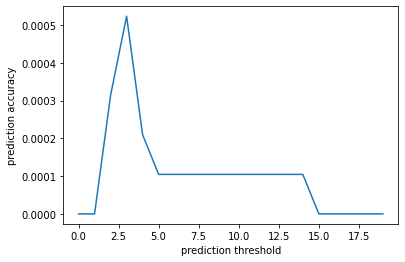

In [6]:
#review prediction accuracy by threshold
plt.plot(cutoff, hit_rate)
plt.xlabel('prediction threshold')
plt.ylabel('prediction accuracy')
plt.show

In [9]:
#which cutoff maximizes element ID accuracy
max_acc_ind = hit_rate.argmax()
print(f"max accuracy: { hit_rate[max_acc_ind]}")
print(f"at threshold: {cutoff[max_acc_ind]}")
#a cutoff of 10 maximizes prediction accuracy, refine within this range to one decimal point

max accuracy: 0.4901673640167364
at threshold: 3.0


In [6]:
hit_rate2 = np.zeros(len(np.arange(2,4,0.1)))
cutoff2 = np.zeros(len(np.arange(2,4,0.1)))
j= 0 #index for threshold accuracy array
for thresh in np.arange(2,4,0.1):
    matches = 0 #track the correct element predictions at this threshold
    for i in range(len(pred)):
        match = np.array_equal((np.max(pred[i,0:max_z,:], axis=1) > thresh), (fracs[i] > 0))
        matches += 1*match
    cutoff2[j] = thresh
    hit_rate2[j] = matches / len(pred)
    j += 1

<function matplotlib.pyplot.show(close=None, block=None)>

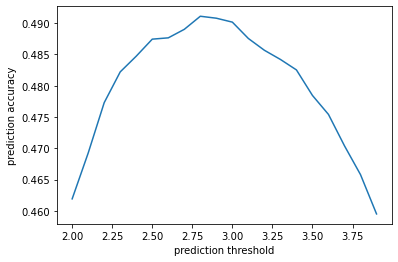

In [7]:
#review prediction accuracy by threshold
plt.plot(cutoff2, hit_rate2)
plt.xlabel('prediction threshold')
plt.ylabel('prediction accuracy')
plt.show

In [8]:
#which cutoff maximizes element ID accuracy
max_acc_ind = hit_rate2.argmax()
print(f"max accuracy: { hit_rate2[max_acc_ind]}")
print(f"at threshold: {cutoff2[max_acc_ind]}")
#no real improvement so we'll stick with 7 for simplicity

max accuracy: 0.49110878661087864
at threshold: 2.8000000000000007


In [9]:
#characterize the nature of missed predictions in training/validation set
# for each element how often missed
# for each element how often incorrectly predicted
false_neg_dict = {}
false_pos_dict = {}
thresh = 2.8
for el in elem_symb:
    false_neg_dict[el] = 0
    false_pos_dict[el] = 0

for i in range(len(pred)):
    match = np.array_equal((np.max(pred[i,0:max_z,:], axis=1) > thresh), (fracs[i] > 0))
    if not match:
        sample_el = elem_symb[fracs[i] > 0]
        pred_el = elem_symb[np.max(pred[i,0:max_z,:], axis=1) > thresh]
        #log any missed elements
        for el in sample_el:
            if el not in pred_el:
                false_neg_dict[el] += 1
        #log any false predictions
        for el in pred_el:
            if el not in sample_el:
                false_pos_dict[el] += 1

<BarContainer object of 80 artists>

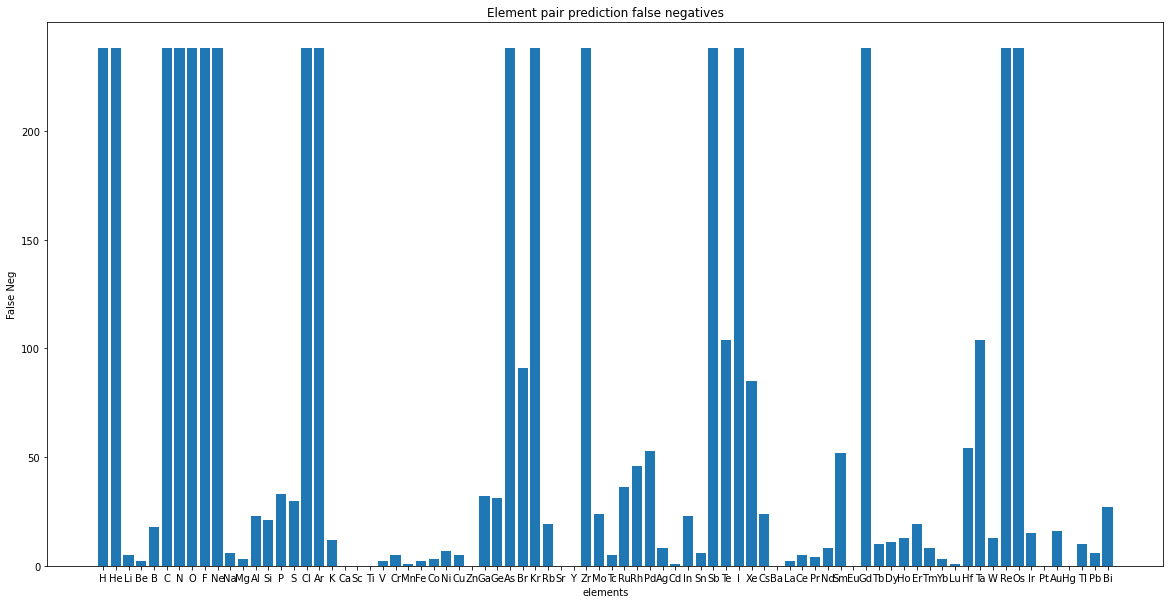

In [10]:
#Visualize false negatives
f_neg_x = np.array([])
f_neg_y = np.array([])
for x, y in false_neg_dict.items():
    f_neg_x = np.append(f_neg_x, x)
    f_neg_y = np.append(f_neg_y, y)
fig, ax = plt.subplots(figsize=(20,10))
ax.set_xlabel('elements')  # Add an x-label to the axes.
ax.set_ylabel('False Neg')  # Add a y-label to the axes.
ax.set_title('Element pair prediction false negatives')  # Add a title to the axes.
ax.bar(f_neg_x, f_neg_y)

<BarContainer object of 80 artists>

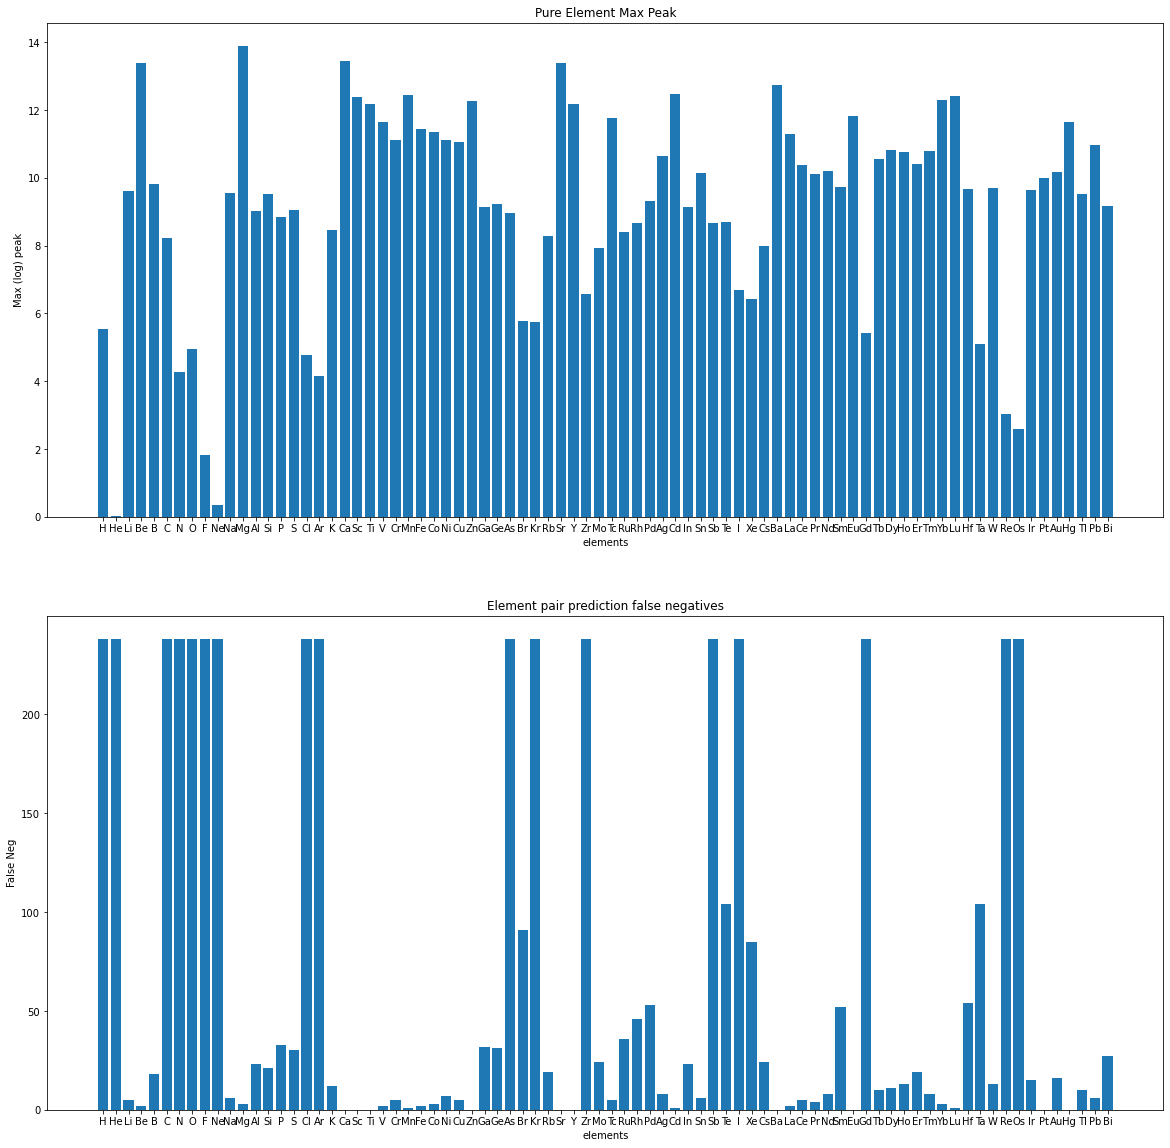

In [19]:
#Calculate the log of the most prominent peak for each element
#This is indicative of signal that the model has to scale/learn
max_log_int = np.zeros(len(elem_symb))
for i in range(len(elem_symb)):
    max_log_int[i] = torch.max(x_data[i][0])

fig, ax = plt.subplots(2,1, figsize=(20,20)) 
ax[0].set_xlabel('elements')  # Add an x-label to the axes.
ax[0].set_ylabel('Max (log) peak')  # Add a y-label to the axes.
ax[0].set_title('Pure Element Max Peak')  # Add a title to the axes.
ax[0].bar(elem_symb, max_log_int)
ax[1].set_xlabel('elements')  # Add an x-label to the axes.
ax[1].set_ylabel('False Neg')  # Add a y-label to the axes.
ax[1].set_title('Element pair prediction false negatives')  # Add a title to the axes.
ax[1].bar(f_neg_x, f_neg_y)


In [20]:
#Check if the pure elements were identified/learned
#This informs whether rescaling / iteration will likely work
for i in range(max_z):
    match = np.array_equal((np.max(pred[i,0:max_z,:], axis=1) > thresh), (fracs[i] > 0))
    if not match:
        print(f"missed element: {elem_symb[i]}")

missed element: H
missed element: He
missed element: C
missed element: N
missed element: O
missed element: F
missed element: Ne
missed element: Cl
missed element: Ar
missed element: As
missed element: Kr
missed element: Zr
missed element: Sb
missed element: I
missed element: Gd
missed element: Re
missed element: Os


<BarContainer object of 80 artists>

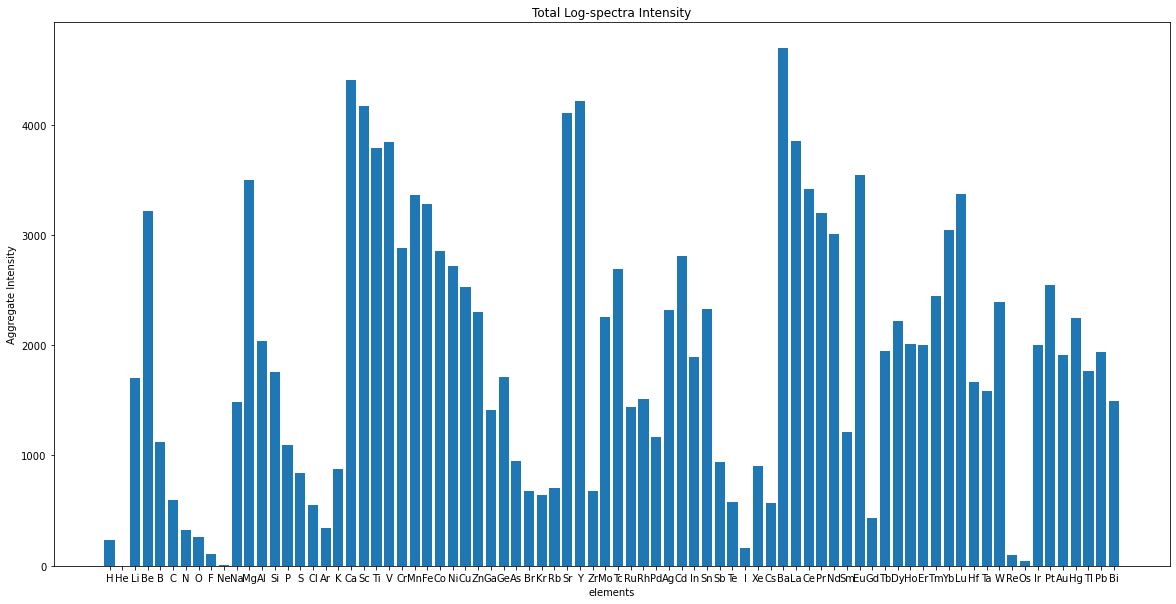

In [22]:
#To force model to train more on these missed elements we can modify the Loss function
#Our loss is MSE applied evenly across all 80 elements in the y_data arrays vs. pred arrays
#Max peak is a single point but maybe more meaningful to consider total intensity as scaling factor
el_tot_int = np.zeros(len(elem_symb))
for i in range(len(elem_symb)):
    el_tot_int[i] = torch.sum(x_data[i][0])

fig, ax = plt.subplots(figsize=(20,10))
ax.set_xlabel('elements')  # Add an x-label to the axes.
ax.set_ylabel('Aggregate Intensity')  # Add a y-label to the axes.
ax.set_title('Total Log-spectra Intensity')  # Add a title to the axes.
ax.bar(elem_symb, el_tot_int)

In [74]:
#Persist the aggregated log-int data for use in training loss function
#with open(datapath / 'training' / 'el80_log_int.pickle', 'wb') as f:
#    pickle.dump(el_tot_int, f)

#To load
with open(datapath / 'training' / 'el80_log_int.pickle', 'rb') as f:
   el_tot_int = pickle.load(f).astype('float32')

In [89]:
#quick check on batch mulitplication since batch=n, rows =m
#and we have 1D tensor of weights m
batched = torch.rand(5,3)
weights = torch.tensor([0,1,2])
print(batched)
print(weights)
print(torch.mul(batched,weights))

tensor([[0.0134, 0.1670, 0.6769],
        [0.9674, 0.6363, 0.9640],
        [0.8880, 0.1915, 0.3168],
        [0.0643, 0.1197, 0.1531],
        [0.6057, 0.9798, 0.5136]])
tensor([0, 1, 2])
tensor([[0.0000, 0.1670, 1.3539],
        [0.0000, 0.6363, 1.9281],
        [0.0000, 0.1915, 0.6336],
        [0.0000, 0.1197, 0.3063],
        [0.0000, 0.9798, 1.0272]])


In [93]:
#develop custom loss function (imported at top)
loss_wts = 1000 * torch.tensor(1 / el_tot_int)
min_wt = torch.min(loss_wts)
max_wt = torch.max(loss_wts)
avg_wt = torch.mean(loss_wts)
#concatenate average weighting for artifact/noise channels
loss_wts = torch.cat((loss_wts, torch.tensor([avg_wt, avg_wt])),dim = 0)
print(f"loss wts shape {loss_wts.shape}")
print(f"loss_wts, min: {min_wt}, max: {max_wt}, avg: {avg_wt}")
i_samp = 2022
y_target = y_data[i_samp:i_samp+10]
print(y_target.shape)
y_pred = model(x_data[i_samp:i_samp+10])
print(y_pred.shape)
el_err = torch.sum(((y_pred - y_target) ** 2), axis=2)
print(f"sum errors shape {el_err.shape}")
el_wt_loss = torch.mul(el_err, loss_wts)
print(f"loss shape :{el_wt_loss.shape}")
mean_loss = torch.mean(el_wt_loss)
print(f"weighted MSE: {mean_loss}")


loss wts shape torch.Size([82])
loss_wts, min: 0.21309742331504822, max: 8499.81640625, avg: 108.67227935791016
torch.Size([10, 82, 782])
torch.Size([10, 82, 782])
sum errors shape torch.Size([10, 82])
loss shape :torch.Size([10, 82])
weighted MSE: 144.5961151123047


<BarContainer object of 80 artists>

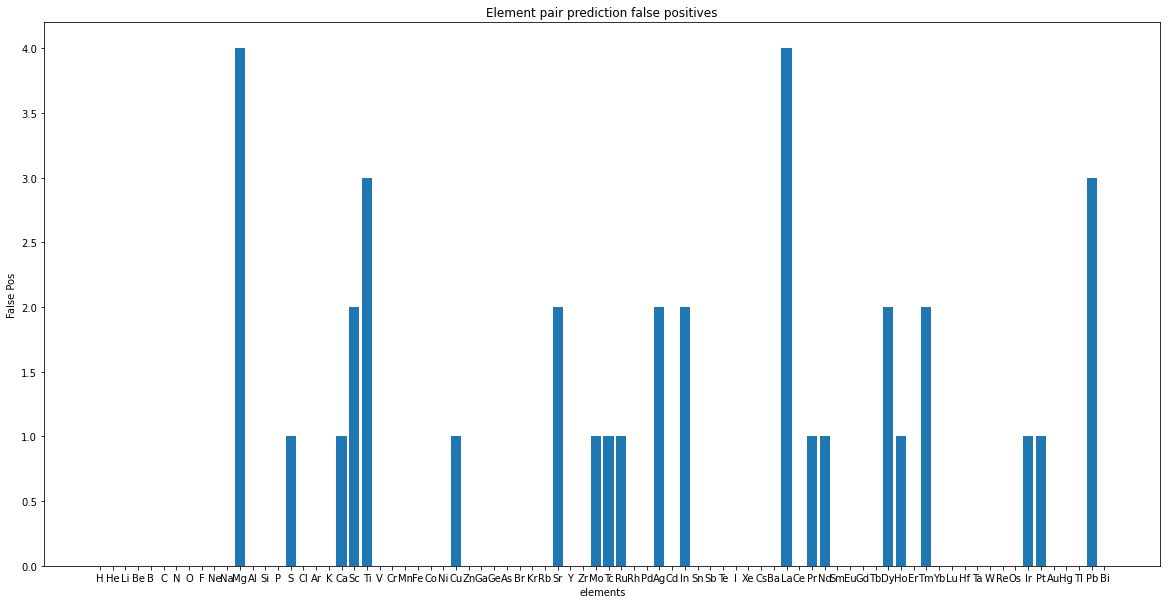

In [18]:
#Visualize false positives
f_pos_x = np.array([])
f_pos_y = np.array([])
for x, y in false_pos_dict.items():
    f_pos_x = np.append(f_pos_x, x)
    f_pos_y = np.append(f_pos_y, y)
fig, ax = plt.subplots(figsize=(20,10))
ax.set_xlabel('elements')  # Add an x-label to the axes.
ax.set_ylabel('False Pos')  # Add a y-label to the axes.
ax.set_title('Element pair prediction false positives')  # Add a title to the axes.
ax.bar(f_pos_x, f_pos_y)

In [6]:
#check if this model can identify elements in Li2CO3
#with open(datapath / 'training' / 'el80_pairs_meta.pickle', 'rb') as f:
#    wave = pickle.load(f)
#    elem_symb = pickle.load(f)
#    el_index = pickle.load(f)

max_z = len(elem_symb)
spec_maker = spectrum_maker()
fracs_dict = {'Li':0.333, 'C':0.167, 'O':0.5}
wave, spec_dict, lines_dict = spec_maker.make_spectra(fracs_dict)

y_custom = np.zeros((max_z + 2, len(wave)))
for el in spec_dict.keys():
    if el == 'art':
        y_custom[max_z] = spec_dict[el]
    elif el == 'noi':
        y_custom[max_z + 1] = spec_dict[el]
    elif el == 'comp':
        x_custom = spec_dict['comp']
    else:
        y_custom[el_index[el]] = spec_dict[el]

In [8]:
#scale and dimension data for model

x_custom = nist_sim_mult * torch.tensor(x_custom[None,None,:].astype('float32'))
y_custom = nist_sim_mult * torch.tensor(y_custom[None,:,:].astype('float32'))
x_custom[x_custom < 0] = 0
y_custom[y_custom < 0] = 0
#log transform data, add small offset 1 so zero points remain ~zero on log scale
x_custom = torch.log(x_custom + 1)
y_custom = torch.log(y_custom + 1)

model.eval()
with torch.no_grad():
    pred_c = model(x_custom).detach().numpy()

#see which elements are predicted
thresh = 3
pred_c_idx = np.max(pred_c[0,0:max_z,:], axis=1) > thresh
elem_symb[pred_c_idx] #array(['Li'], dtype='<U2')

array(['Li'], dtype='<U2')

In this next section we develop a recursive process that will:
1. Identify elements present with trained model (set evolves with recursion)
2. Determine relative weights of identified elements with L-S fit to input spectrum
3. Calculate residual spectrum and truncate negative intensities
4. If there is a material positive peak (> 0.5 threshold), rescale to 2x threshold
5. Begin process again with residual spectrum, note step 2 builds on prior elements

Note that we re-run L-S fit of atomic spectra to input spectrum with all elements identified. We want to have a conservative "stopping condition" such that we favor first elements selected by ML model. As such we should inspect the loss value as each element is added to ensure that (relative to identified weight) the reduction in loss is meaningful.

In [3]:
#generate reference spectra
spec_maker = spectrum_maker()

#create array of reference spectra for elements.
el_spec = np.zeros((max_z,760))
wave = range(190, 950)
for i in range(max_z):
    fracs_dict = {el_symbol[i]:1}
    wave, el_spec[i], spec_dict = spec_maker.make_spectra(fracs_dict)


In [31]:
#save a few elements to file for excel
export_el = np.array(['Li', 'C', 'O', 'N'])
el_mask = np.array([],dtype='int')
header = "wave"
for el in export_el:
    el_mask = np.append(el_mask,el_index[el])
    header += "," + el
np.savetxt('temp_spec.csv', np.concatenate((wave[None,:],el_spec[el_mask]), axis=0).T, delimiter = ',', header=header)

In [22]:
(el_spec[el_mask]).shape

(4, 760)

sum for Li is 1.0


<function matplotlib.pyplot.show(close=None, block=None)>

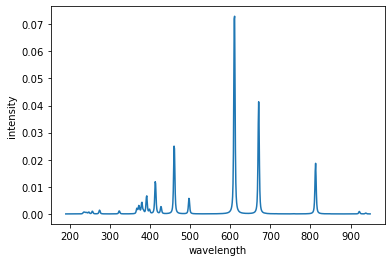

In [14]:
#check spectra
el_ind = 2
print(f"sum for {el_symbol[el_ind]} is {np.sum(el_spec[el_ind])}")
plt.plot(wave, el_spec[el_ind])
plt.xlabel('wavelength')
plt.ylabel('intensity')
plt.show

In [15]:
#Generate predictions for train/valid data
#TODO look into wrapping x_data in data loader. This approach takes 7min and uses ~40Gb swap memory
model.eval()
with torch.no_grad():
    pred = model(x_data).detach().numpy()
#With a threshold established, identify the predicted elements for each sample
thresh = 7
#define a mask vector with 0,1 values to indicate identified elements in train/validation data
el_pred = 1*(np.max(pred[:,0:max_z,:], axis=2) > thresh)

NameError: name 'x_data' is not defined

In [23]:
#next task is to find the linear combination of the present spectra that minimizes error to input spectrum
#Try https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.least_squares.html

sample_num = 400 #0-589 , use index for simplicity
input_log = x_data[sample_num].detach().numpy()
#Note we are fitting in non-transformed space
#x_data = input_scale * torch.log(rel_int_scale * x_data + 1)
input_spec = (np.exp(input_log / input_scale) - 1) / rel_int_scale

#define the residuals function (x = weights, x_spec is dependent, ref_specs are independent)
def fun_fitspec(x, x_spec, ref_specs):
    return np.squeeze(np.sum((ref_specs.transpose() * x).transpose(), axis=0) - x_spec)
#initial weights as even allocation to identified elements
x0 = el_pred[sample_num] / np.sum(el_pred[sample_num]) #start with balanced allocation to candidates
#add bounds to zero out the non-identified elements
#bounds passed as a 2-tuple of vectors ([lower], [upper]) use np.inf for unbounded
#lower bound for all is non-negative weights
bnd_low = np.zeros(max_z)
#upper bound on candidates is 1, for which we can use el_pred mask
#need a small delta to avoid lb = ub
bnd_up = el_pred[sample_num] + 0.001
el_bounds = (bnd_low, bnd_up)
#now adjust upper bounds
el_fit = least_squares(fun_fitspec, x0, args=(input_spec, el_spec), bounds=el_bounds)




In [24]:
#review results
#library does not allow linear constraints so cannot constrain sum of x <=1
#prob ok as we can scale to 1?
fit_wts = el_fit.x.copy()
fit_wts[fit_wts < 0.01] = 0
fit_wts = fit_wts / np.sum(fit_wts)

for i in range(len(fit_wts)):
    if fracs[sample_num][i] > 0 or fit_wts[i] > 0:
        print(f"{el_symbol[i]}: ref: {fracs[sample_num][i]} pred: {np.round(fit_wts[i],3)}")

He: ref: 0.1 pred: 0.1
Br: ref: 0.9 pred: 0.9


<function matplotlib.pyplot.show(close=None, block=None)>

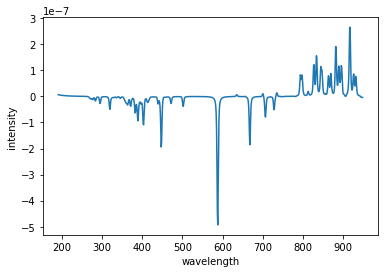

In [25]:
#now subtract this from input spectrum and determine if there is residual signal
#residual can be scaled up and fed into model once again!
resid_spec = np.squeeze(input_spec - np.sum((el_spec.transpose() * fit_wts).transpose(), axis=0))
#the fit will create negative values that we discard to focus on true signals
#resid_spec[resid_spec <0] = 0
plt.plot(wave, resid_spec)
plt.xlabel('wavelength')
plt.ylabel('intensity')
plt.show

In [28]:
print(f"fit SSE {np.sqrt(el_fit.cost)}")
print(f"max resid positive peak: {np.max(resid_spec)}")
print(f"min resid negative peak: {np.min(resid_spec)}")

fit SSE 6.154514016107029e-05
max resid positive peak: 2.6539566652314384e-07
min resid negative peak: -4.932200717688157e-07


In [26]:
#Test arbitrary mixture of elements Li2CO3
fracs_dict = {'Li':0.333, 'C':0.167, 'O':0.5}
#generate input spectrum
wave, test_spec, spec_dict = spec_maker.make_spectra(fracs_dict)
spec_input = np.stack((wave,test_spec), axis = -1)
fit_dict = fit_spec(spec_input)

In [34]:
report_el = np.array([])
for k in fracs_dict.keys():
    report_el = np.append(report_el, k)
for k in fit_dict.keys():
    if k not in report_el:
        report_el = np.append(report_el,k)

for el in report_el:
    input_wt = 0
    if el in fracs_dict:
        input_wt = fracs_dict[el]
    pred_wt = 0
    if el in fit_dict:
        pred_wt = np.round(fit_dict[el],3)
    print(f"{el}: ref: {input_wt} pred: {pred_wt}")


Li: ref: 0.333 pred: 0.333
C: ref: 0.167 pred: 0.167
O: ref: 0.5 pred: 0.5


In [62]:
#Test class wrapping the (to become) full iterative fitting process for experimental spectra
fit_dict = fit_spec(test_spec)
fit_dict #{'Li': 0.333, 'C': 0.167, 'O': 0.5}

{'Li': 0.333, 'C': 0.167, 'O': 0.5}

In [2]:
#Examine experimental spectrum for Li2CO3
libs_spec = np.genfromtxt(datapath / "experimental/LIBS_Li2CO3.csv", delimiter=',', skip_header=1)
fit_dict = fit_spec(libs_spec)
fit_dict

{'Li': 0.8556, 'N': 0.1444}

In [37]:
#put libs spec in same scale as atomic spectra
libs_wave = libs_spec[:,0]
libs_intens = libs_spec[:,1]
wave_dict = {wl:0 for wl in wave}
for i in range(len(libs_wave)):
    int_wl = np.round(libs_wave[i],0)
    if int_wl in wave_dict:
        wave_dict[int_wl] += libs_intens[i]
x_spec = np.array([])
for wl, intens in wave_dict.items():
    x_spec = np.append(x_spec, intens)
x_spec /= np.sum(x_spec)

In [39]:
#generate atomic spectra array el_spec
spec_maker = spectrum_maker()
el_spec = np.zeros((max_z,760))
for i in range(max_z):
    fracs_dict = {el_symbol[i]:1}
    wave, el_spec[i], spec_dict = spec_maker.make_spectra(fracs_dict)

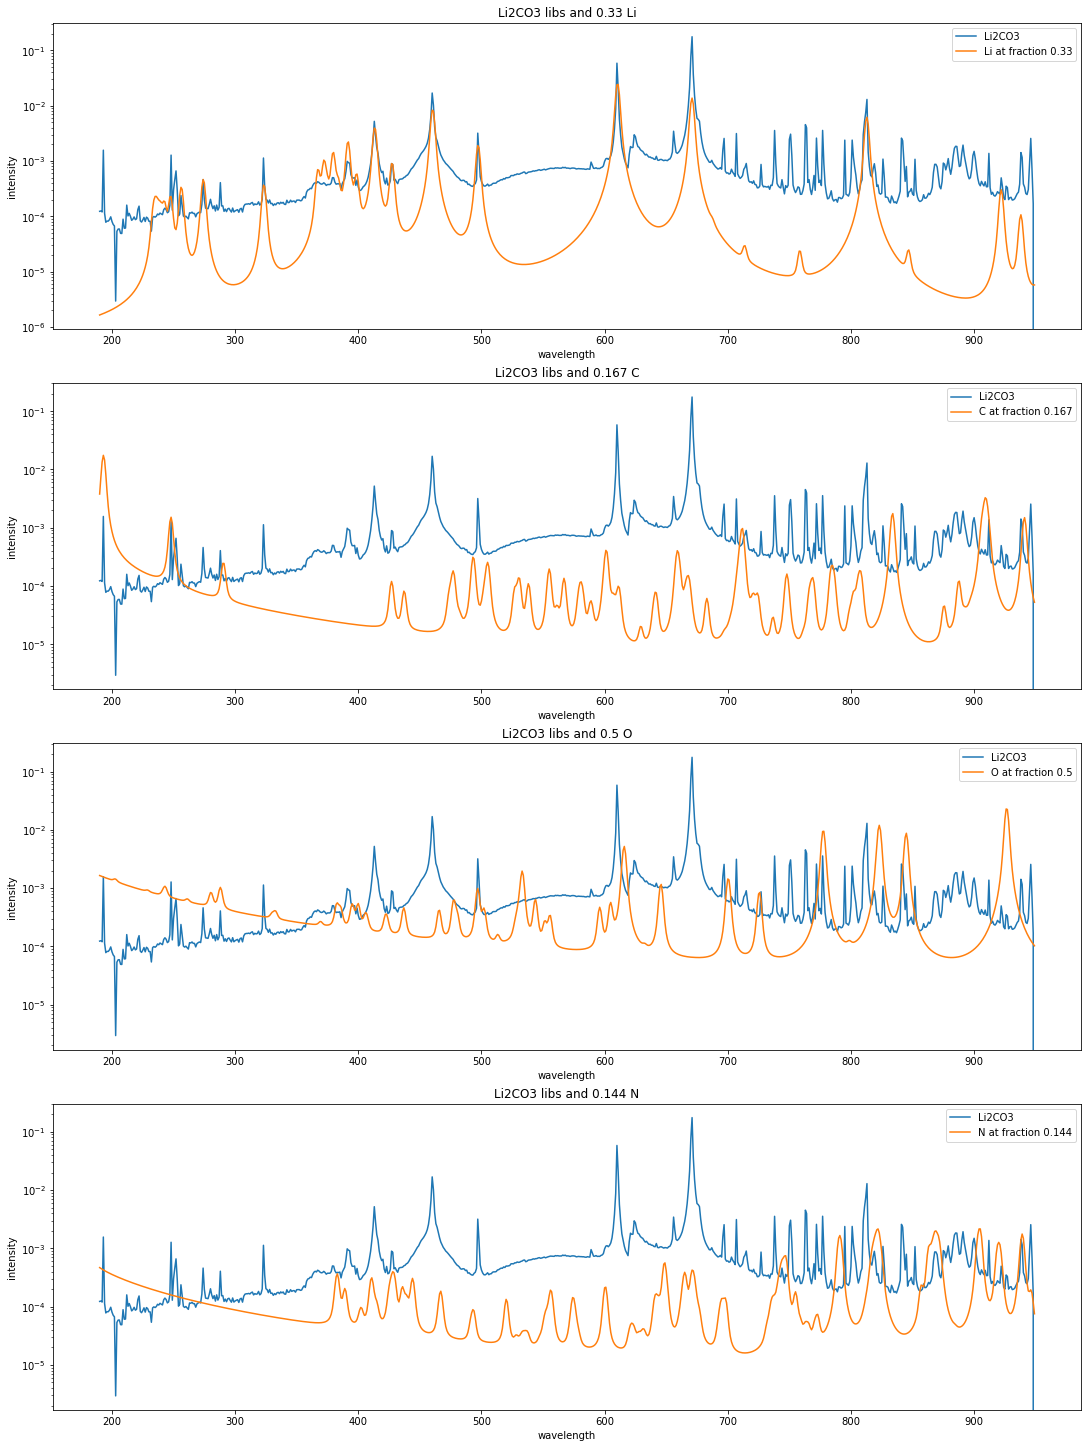

In [86]:
#Plot experimental spectrum with atomic spectra overlays
plot_el = {'Li':0.33, 'C':0.167, 'O':0.5, 'N':0.144}
my_fig, my_axes = plt.subplots(4,1, figsize=(15,20), constrained_layout=True)
i = 0
for el in plot_el:
    my_axes[i].set_xlabel('wavelength')
    my_axes[i].set_ylabel('intensity')
    my_axes[i].set_title(f'Li2CO3 libs and {plot_el[el]} {el}')
    my_axes[i].set_yscale('log')
    my_axes[i].plot(wave, x_spec, label = 'Li2CO3')
    my_axes[i].plot(wave, plot_el[el] * el_spec[el_index[el]], label = f'{el} at fraction {plot_el[el]}')
    my_axes[i].legend()
    i += 1
